<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf2/time-series-rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Time Series data: Recurrent Neural Networks

* Nice tutorial: https://www.tensorflow.org/beta/tutorials/text/time_series

In [0]:
import pandas as pd
import numpy as np

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
# plt.xkcd()
# plt.style.use('ggplot')

In [0]:
# for local
# url = 'opsd_germany_daily.csv'

# for colab
url = 'https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv'

time_series_df = pd.read_csv(url, 
                             sep=',', 
                             index_col=0, # you can use the date as the index for pandas
                             parse_dates=[0]) # where is the time stamp?

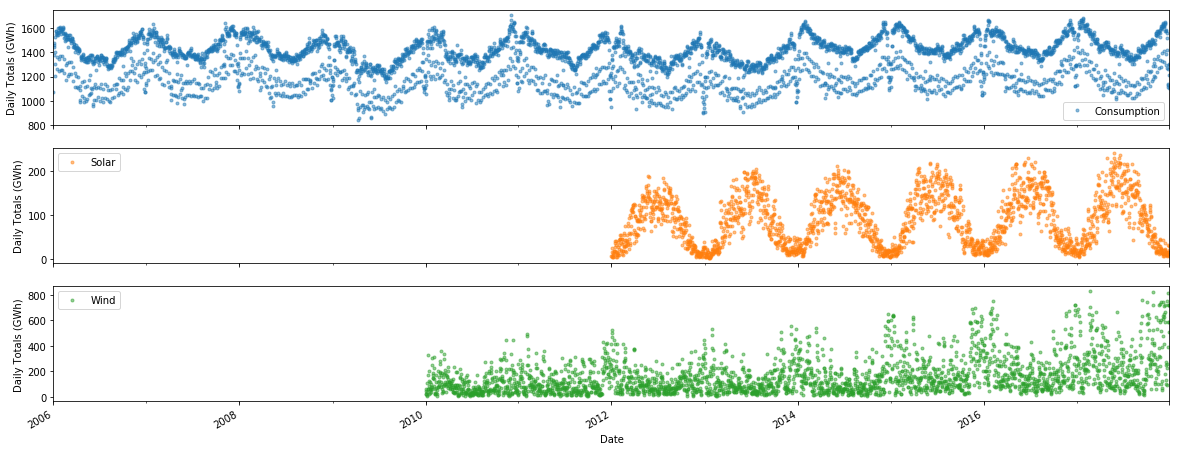

In [4]:
cols_plot = ['Consumption', 'Solar', 'Wind']

axes = time_series_df[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(20, 8), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily Totals (GWh)')

## Recurrent Neural Networks

* Consume input using RNNs
* Spit out prediction in one chunk using a single Dense layer

In [5]:
days_2016_2017 = time_series_df['2016': '2017']['Consumption'].to_numpy()
days_2016_2017.shape

(731,)

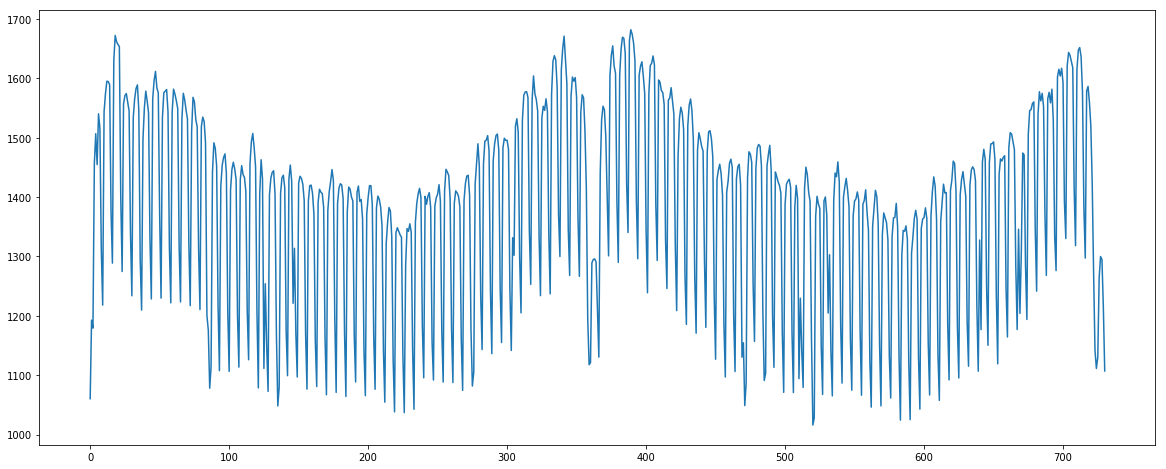

In [6]:
plt.figure(figsize=(20, 8))
plt.plot(days_2016_2017);

In [0]:
# derived from here: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

### For each week predict the next one (or two or three or four)

In [0]:
#@title Prediction from n days to m days

# https://colab.research.google.com/notebooks/forms.ipynb


n_steps_in = 7 #@param {type:"slider", min:1, max:100, step:1}
n_steps_out = 14 #@param {type:"slider", min:1, max:100, step:1}

In [9]:
X, Y = split_sequence(days_2016_2017, n_steps_in, n_steps_out)
X.shape, Y.shape

((711, 7), (711, 14))

In [10]:
X[0], Y[0]

(array([1060.366, 1192.698, 1179.282, 1456.294, 1506.737, 1454.685,
        1540.304]),
 array([1515.84 , 1311.996, 1217.985, 1543.692, 1574.058, 1595.181,
        1594.6  , 1589.38 , 1376.513, 1288.699, 1629.911, 1672.32 ,
        1661.646, 1657.049]))

In [11]:
X[1], Y[1]

(array([1192.698, 1179.282, 1456.294, 1506.737, 1454.685, 1540.304,
        1515.84 ]),
 array([1311.996, 1217.985, 1543.692, 1574.058, 1595.181, 1594.6  ,
        1589.38 , 1376.513, 1288.699, 1629.911, 1672.32 , 1661.646,
        1657.049, 1653.635]))

In [12]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X.shape

(711, 7, 1)

In [13]:
# Gives us a well defined version of tensorflow

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [14]:
import tensorflow as tf
print(tf.__version__)

2.0.0-rc1


In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.models import Sequential, Model

model = Sequential()
model.add(GRU(100, activation='relu', input_shape=(n_steps_in, n_features)))
# model.add(GRU(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
# model.add(GRU(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 100)               30900     
_________________________________________________________________
dense (Dense)                (None, 14)                1414      
Total params: 32,314
Trainable params: 32,314
Non-trainable params: 0
_________________________________________________________________


CPU times: user 49.8 s, sys: 4.21 s, total: 54 s
Wall time: 35.4 s


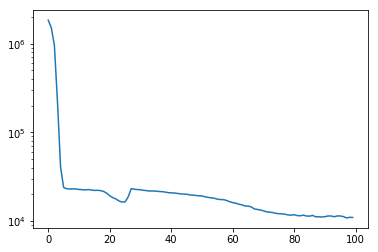

In [16]:
%%time

history = model.fit(X, Y, epochs=100, verbose=0)
plt.yscale('log')
plt.plot(history.history['loss'])

In [17]:
model.evaluate(X, Y, verbose=0)

10729.580295138889

In [18]:
final_week_2017 = X[-1]
final_week_2017

array([[1614.15862],
       [1647.36346],
       [1651.90418],
       [1636.54375],
       [1576.93197],
       [1382.87708],
       [1297.21916]])

In [19]:
first_week_2018 = model.predict(final_week_2017.reshape(1, -1, 1))
first_week_2018

array([[1490.7634, 1617.1746, 1671.6497, 1637.511 , 1494.5547, 1362.3798,
        1393.9806, 1534.639 , 1622.5675, 1676.9923, 1651.1144, 1500.287 ,
        1366.7688, 1374.2859]], dtype=float32)

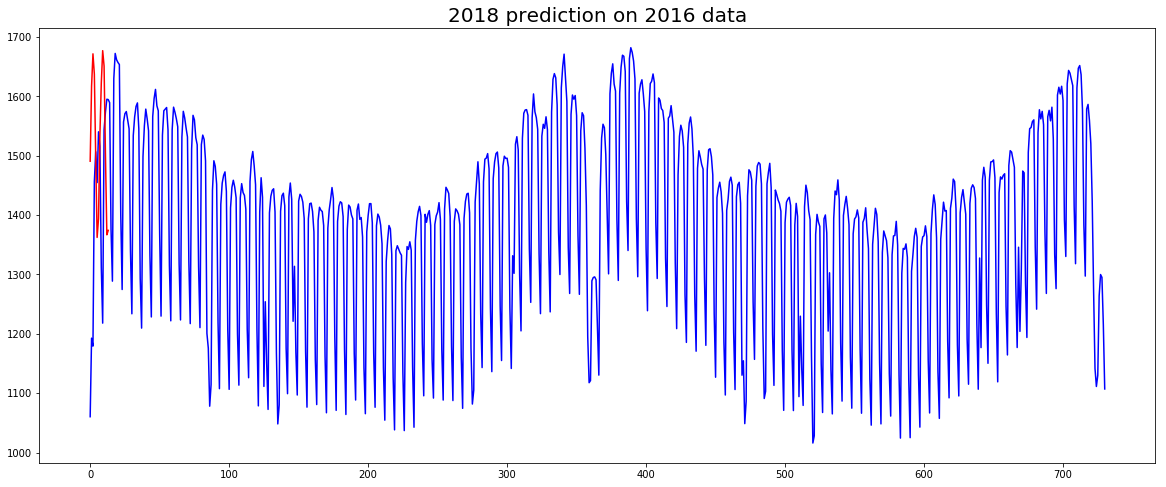

In [20]:
plt.figure(figsize=(20, 8))

plt.plot(days_2016_2017, color='b')
plt.plot(first_week_2018[0], color='r')
plt.title('2018 prediction on 2016 data', fontsize=20);

In [0]:
known_x = np.arange(len(days_2016_2017))
pred_x = np.arange(len(days_2016_2017), len(days_2016_2017) + n_steps_out)

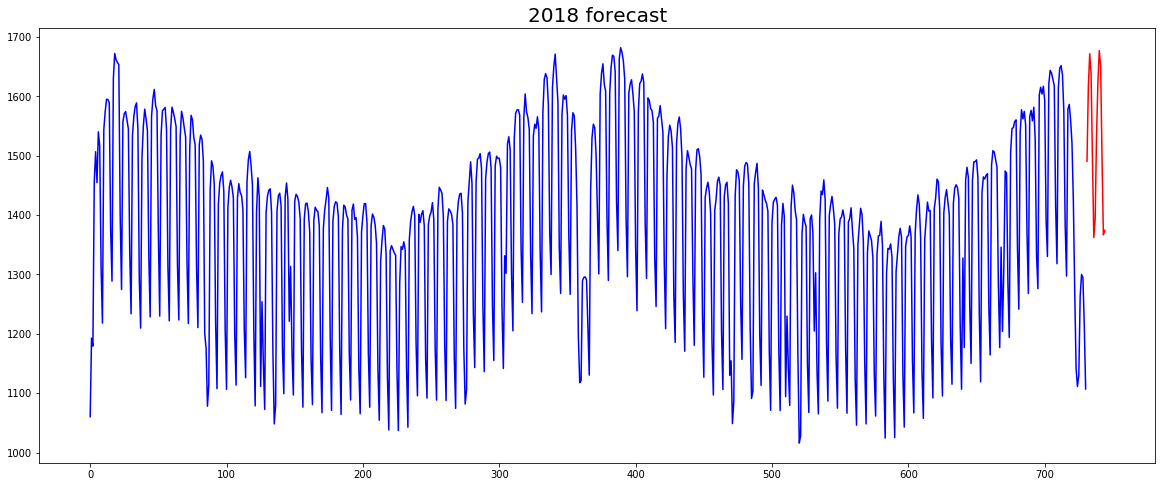

In [22]:
plt.figure(figsize=(20, 8))

plt.plot(known_x, days_2016_2017, color='b')
plt.plot(pred_x, first_week_2018[0], color='r')
plt.title('2018 forecast', fontsize=20);

### For each month predict the next one

In [0]:
#@title Prediction from n days to m days

n_steps_in = 30 #@param {type:"slider", min:1, max:100, step:1}
n_steps_out = 30 #@param {type:"slider", min:1, max:100, step:1}

In [24]:
X, Y = split_sequence(days_2016_2017, n_steps_in, n_steps_out)
X.shape, Y.shape

((672, 30), (672, 30))

In [25]:
X[0], Y[0]

(array([1060.366, 1192.698, 1179.282, 1456.294, 1506.737, 1454.685,
        1540.304, 1515.84 , 1311.996, 1217.985, 1543.692, 1574.058,
        1595.181, 1594.6  , 1589.38 , 1376.513, 1288.699, 1629.911,
        1672.32 , 1661.646, 1657.049, 1653.635, 1400.292, 1274.629,
        1556.816, 1570.884, 1574.427, 1559.91 , 1545.318, 1339.319]),
 array([1233.714, 1533.857, 1565.493, 1583.04 , 1588.979, 1545.368,
        1293.588, 1209.617, 1498.211, 1550.349, 1578.526, 1562.214,
        1541.945, 1331.757, 1228.404, 1565.899, 1596.259, 1611.729,
        1584.18 , 1575.679, 1366.934, 1229.811, 1534.638, 1575.798,
        1578.573, 1581.22 , 1543.553, 1314.531, 1221.887, 1544.11 ]))

In [26]:
X[1], Y[1]

(array([1192.698, 1179.282, 1456.294, 1506.737, 1454.685, 1540.304,
        1515.84 , 1311.996, 1217.985, 1543.692, 1574.058, 1595.181,
        1594.6  , 1589.38 , 1376.513, 1288.699, 1629.911, 1672.32 ,
        1661.646, 1657.049, 1653.635, 1400.292, 1274.629, 1556.816,
        1570.884, 1574.427, 1559.91 , 1545.318, 1339.319, 1233.714]),
 array([1533.857, 1565.493, 1583.04 , 1588.979, 1545.368, 1293.588,
        1209.617, 1498.211, 1550.349, 1578.526, 1562.214, 1541.945,
        1331.757, 1228.404, 1565.899, 1596.259, 1611.729, 1584.18 ,
        1575.679, 1366.934, 1229.811, 1534.638, 1575.798, 1578.573,
        1581.22 , 1543.553, 1314.531, 1221.887, 1544.11 , 1581.822]))

In [27]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X.shape

(672, 30, 1)

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.models import Sequential, Model

model = Sequential()
model.add(GRU(100, activation='relu', input_shape=(n_steps_in, n_features)))
# model.add(GRU(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
# model.add(GRU(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 100)               30900     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                3030      
Total params: 33,930
Trainable params: 33,930
Non-trainable params: 0
_________________________________________________________________


CPU times: user 5min, sys: 25.5 s, total: 5min 26s
Wall time: 3min 29s


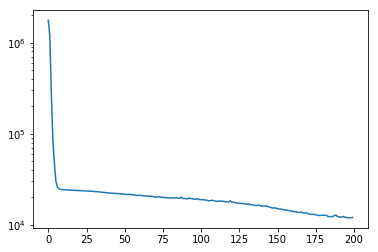

In [29]:
%%time

history = model.fit(X, Y, epochs=200, verbose=0)
plt.yscale('log')
plt.plot(history.history['loss'])

In [30]:
model.evaluate(X, Y, verbose=0)

11949.209519159227

In [31]:
final_2017 = X[-1]
final_2017

array([[1474.19484],
       [1471.18241],
       [1284.77485],
       [1193.85495],
       [1505.67173],
       [1545.63945],
       [1547.48171],
       [1557.63091],
       [1560.41732],
       [1346.43916],
       [1241.51495],
       [1538.83561],
       [1577.45348],
       [1562.03367],
       [1574.73479],
       [1552.2178 ],
       [1369.91888],
       [1268.00462],
       [1565.56805],
       [1576.49592],
       [1558.72998],
       [1581.7877 ],
       [1528.12694],
       [1333.15585],
       [1276.09818],
       [1602.17797],
       [1615.38061],
       [1603.98435],
       [1617.03309],
       [1592.96187]])

In [32]:
first_2018 = model.predict(final_2017.reshape(1, n_steps_in, 1))
first_2018

array([[1422.44  , 1355.2754, 1398.319 , 1538.7673, 1620.0079, 1596.9938,
        1517.6262, 1405.3123, 1356.349 , 1415.5469, 1591.7416, 1638.6632,
        1622.6323, 1534.8414, 1426.4827, 1365.8308, 1406.9685, 1549.0883,
        1630.4556, 1603.4496, 1520.497 , 1397.2329, 1350.4327, 1392.4844,
        1549.9282, 1601.9607, 1605.729 , 1532.725 , 1389.2935, 1366.5349]],
      dtype=float32)

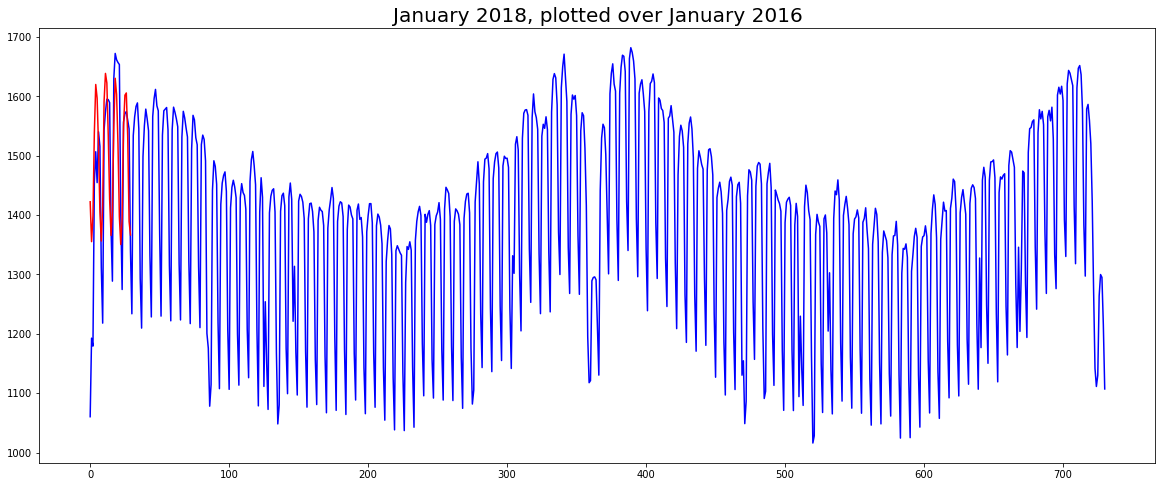

In [33]:
plt.figure(figsize=(20, 8))

plt.plot(days_2016_2017, color='b')
plt.plot(first_2018[0], color='r')
plt.title('January 2018, plotted over January 2016', fontsize=20);

In [0]:
known_x = np.arange(len(days_2016_2017))
pred_x = np.arange(len(days_2016_2017), len(days_2016_2017) + n_steps_out)

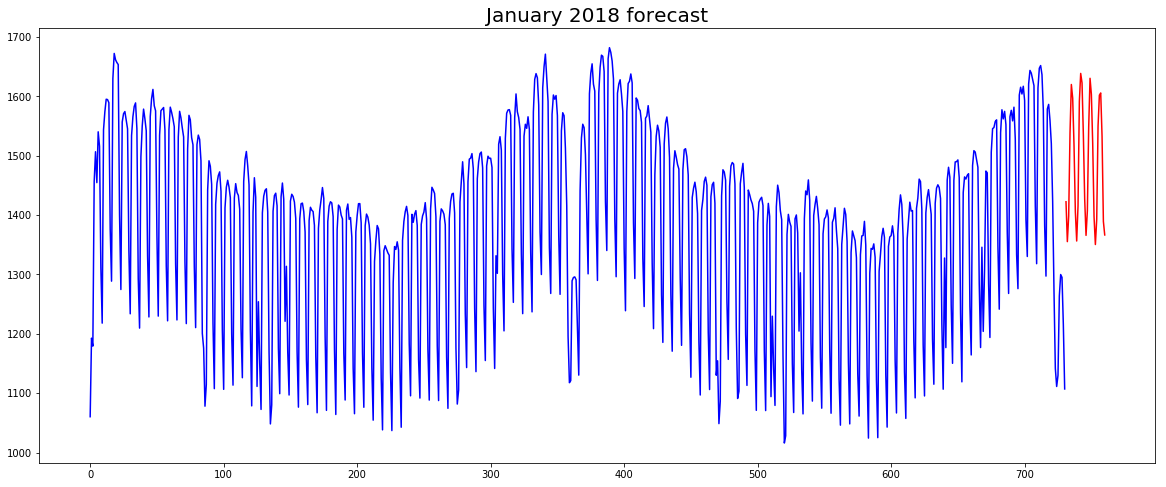

In [35]:
plt.figure(figsize=(20, 8))

plt.plot(known_x, days_2016_2017, color='b')
plt.plot(pred_x, first_2018[0], color='r')

plt.title('January 2018 forecast', fontsize=20);